In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import generative as gen
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
import utils as ut
import seaborn as sns
from vizman import viz
from scipy import io
import pandas as pd
from brainspace.utils import parcellation
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from netneurotools.networks import struct_consensus


/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
viz.set_visual_style()
viz_sizes = viz.load_data_from_json("sizes.json")
viz_colors = viz.load_data_from_json("colors.json")
viz_cmaps = viz.give_colormaps()
sns_kwargs = {"cmap": viz_cmaps["bw_lr"],
              "xticklabels":False,
              "yticklabels":False,
              "rasterized":True}

surfcolors = sns.blend_palette([
                                viz_colors["neutrals"]["ALL_WHITE"],
                                viz_colors["warms"]["LECKER_RED"]],
                                     as_cmap=True)

In [4]:
data = io.loadmat(
    "datasets/human/lifespan/lifespan_project_data.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)

In [5]:
data["lifespan_project_data"]["sample"]["info"]

array(['Sex: male = 0, female = 1',
       'Study_ids contains ids for each study - for BCP this includes the session and scan type',
       'Subject_ids are numbers that are unique to each unique subject and repeat for index that contain the same subject but different scan (either session or scan type)',
       'Atlas: neonatal = 1; 1-year-old = 2, 2-year-old = 3; adult = 4',
       'Study: dHCP = 1, BCP = 2 , CALM = 3, RED = 4, ACE = 5, HCPd = 6, HCPya = 7, camCAN = 8, HCPa = 9',
       'Neurogroup: neurotypical = 1, neurodiverse = 2'], dtype=object)

In [6]:
data["lifespan_project_data"]["sample"].keys()

dict_keys(['info', 'study_ids', 'subject_ids', 'ages', 'sex', 'atlas', 'studies', 'neurogroup'])

In [7]:
test = data["lifespan_project_data"]["connectomes"]["unthresholded"][1,:,:]
nx.is_connected(nx.from_numpy_array(test))

False

In [8]:
#connectomes = data["lifespan_project_data"]["connectomes"]["controlled_density"]["binarised"]
connectomes = data["lifespan_project_data"]["connectomes"]["variable_density"]["binarised"]


In [9]:
weighted_connectomes = data["lifespan_project_data"]["connectomes"]["variable_density"]["normalised_weighted"]

In [10]:
atlas = io.loadmat(
    "datasets/human/lifespan/aal90.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)

In [11]:
labels = atlas["aal90"]["region_labels"]
coordinates = atlas["aal90"]["coor_adult"]
euclidean_distances = squareform(pdist(coordinates))

lh_vertex_labels = np.load("./datasets/human/lifespan/AAL90_lh_labels.npy")
rh_vertex_labels = np.load("./datasets/human/lifespan/AAL90_rh_labels.npy")

In [12]:
info = pd.DataFrame({"sex": data["lifespan_project_data"]["sample"]["sex"],
                     "subject_ids": data["lifespan_project_data"]["sample"]["subject_ids"],
                     "atlas": data["lifespan_project_data"]["sample"]["atlas"],
                     "ages": data["lifespan_project_data"]["sample"]["ages"],
                     "studies": data["lifespan_project_data"]["sample"]["studies"],
                     "neurogroup": data["lifespan_project_data"]["sample"]["neurogroup"],})

In [13]:
hcp_ya = connectomes[info["studies"] == 7].transpose(1, 2, 0)
hcp_ya.shape

(90, 90, 1062)

In [14]:
(connectomes[info["studies"] == 7][0,:,:] == hcp_ya[:,:,0]).all()

True

In [15]:
connectedness = []
for i in range(hcp_ya.shape[2]):
    G = nx.from_numpy_array(hcp_ya[:,:,i])
    connectedness.append(nx.is_connected(G))
np.sum(connectedness)

373

In [16]:
hcp_ya = hcp_ya[:,:,connectedness]
hcp_ya.shape

(90, 90, 373)

In [17]:
empirical_densities = np.array([ut.check_density(hcp_ya[:,:,i]) for i in range(hcp_ya.shape[2])])

In [18]:
hemiid = np.zeros(90)
hemiid[::2] = 1  # Set every even index to 1

In [19]:
weighted_hcp_ya = weighted_connectomes[info["studies"] == 7].transpose(1, 2, 0)
empirical_consensus = struct_consensus(weighted_hcp_ya, 
                                       distance=euclidean_distances,
                                       hemiid=hemiid.reshape(-1, 1))

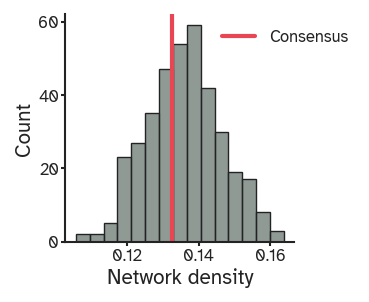

In [20]:
plt.figure(figsize=viz.cm_to_inch((5,5)), dpi=150)
sns.histplot(empirical_densities)
plt.axvline(ut.check_density(empirical_consensus),
            lw=2,color=viz_colors["warms"]["LECKER_RED"],label="Consensus")
plt.xlabel("Network density")
plt.legend(bbox_to_anchor=(1.3,1),frameon=False)
sns.despine()
#plt.savefig("figures/res1_allconns_density_histplot.pdf",dpi=600,bbox_inches='tight');

In [21]:
nx.is_connected(nx.from_numpy_array(empirical_consensus))

False

In [22]:
# Get the connected components
components = list(nx.connected_components(nx.from_numpy_array(empirical_consensus)))

if len(components) > 1:
    node_from = min(components[0])  # node from first component
    node_to = min(components[1])    # node from second component    
    # Add edge between components
    empirical_consensus[node_from, node_to] = 1
    empirical_consensus[node_to, node_from] = 1  # Since it's undirected


In [23]:
nx.is_connected(nx.from_numpy_array(empirical_consensus))

True

In [24]:
ut.check_density(empirical_consensus)

0.13283395755305868

In [25]:
empirical_densities.mean()

0.13588911983345214

In [26]:
n_iterations = 5_000
n_nodes = labels.shape[0]
beta = np.full(n_iterations, 1)
noise = np.zeros(n_iterations)
penalty = np.zeros(n_iterations)
batch_size = np.full(n_iterations, 9)
start = 1
stop = 11
params = np.linspace(start, stop, 11)

In [27]:
params

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [29]:
# scores = np.zeros(len(params))
# histories = np.zeros((n_nodes, n_nodes, n_iterations, len(params)))
# densities = np.zeros(len(params))
# for ind, val in enumerate(params):
#     alpha = np.full(n_iterations, val)
#     histories[...,ind] = gen.simulate_network_evolution(
#         coordinates=coordinates,
#         n_iterations=n_iterations,
#         alpha=alpha,
#         beta=np.full(n_iterations, 1),
#         noise=noise,
#         distance_fn=gen.propagation_distance,
#         connectivity_penalty=penalty,
#         n_jobs=-1,
#         random_seed=11,
#         batch_size=batch_size,
#     )
#     scores[ind] = ut.density_distance(histories[:,:,-1,ind],
#                                       empirical_consensus, 
#                                       absolute=False)
#     densities[ind] = ut.check_density(histories[:,:,-1,ind])
#     print(f"Parameter {val} error: {scores[ind]:.4f}")
# np.save("simulations/propagation_HCPya_5k_scores.npy",scores)
# np.save("simulations/propagation_HCPya_5k_matrices.npy",histories)
# np.save("simulations/propagation_HCPya_5k_densities.npy",densities)

In [30]:
densities = np.load("simulations/propagation_HCPya_5k_densities.npy")
scores = np.load("simulations/propagation_HCPya_5k_scores.npy")
histories = np.load("simulations/propagation_HCPya_5k_matrices.npy")

In [31]:
empirical_densities.std(), empirical_densities.mean()

(0.010399321788857937, 0.13588911983345214)

In [32]:
empirical_densities.mean() - empirical_densities.std(), empirical_densities.mean() + empirical_densities.std()

(0.1254897980445942, 0.14628844162231008)

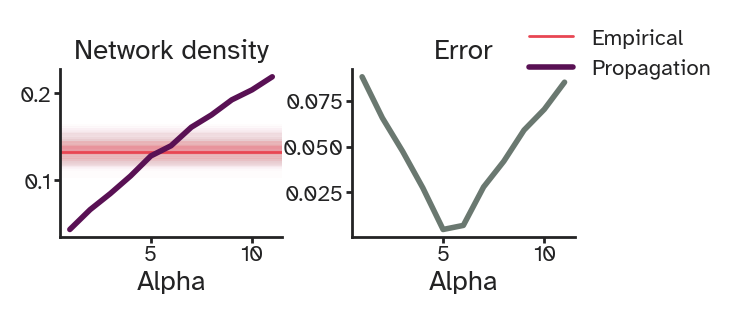

In [34]:

fig, axes = plt.subplot_mosaic([["A", "B"]], 
                               figsize=(viz.cm_to_inch((8,4))),
                               dpi=200,sharex=True)
for subject in range(hcp_ya.shape[2]):
    axes["A"].axhline(empirical_densities[subject],color=viz_colors["warms"]["LECKER_RED"],alpha=0.01)
axes["A"].axhline(ut.check_density(empirical_consensus),
                  color=viz_colors["warms"]["LECKER_RED"],label="Empirical")
axes["A"].plot(params,densities,lw=2,label="Propagation",
               color=viz_colors["purples"]["PURPLER"])


axes["B"].plot(params,np.abs(scores),lw=2)

axes["A"].set_title("Network density")
axes["B"].set_title("Error")
axes["A"].set_xlabel("Alpha")
axes["B"].set_xlabel("Alpha")
fig.legend(bbox_to_anchor=(1.2,1),frameon=False)
fig.tight_layout(w_pad=0.5)
sns.despine()
plt.savefig("figures/HCP/pd_densities_errors.pdf",dpi=600,bbox_inches='tight');

In [35]:
rng = np.random.default_rng(11)

a = rng.normal(params[np.argmin(np.abs(scores))+1],0.5,373)

<Axes: ylabel='Count'>

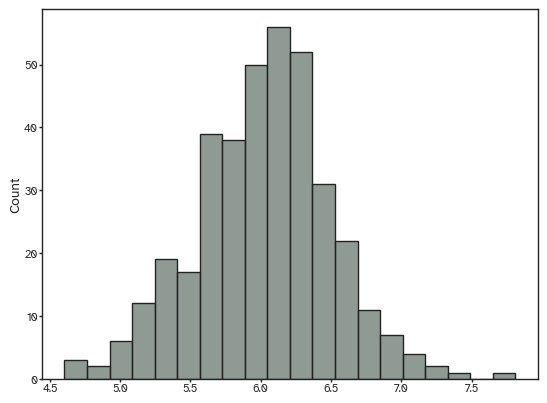

In [36]:
sns.histplot(a)

In [37]:
import h5py

In [38]:
rng = np.random.default_rng(11)
n_iterations = 5000
n_subjects = hcp_ya.shape[2]
n_nodes = labels.shape[0]
alphas = rng.normal(params[np.argmin(np.abs(scores))+1],0.5,n_subjects)

simulated_networks = np.zeros((n_nodes, n_nodes, n_subjects))
# for subject in range(n_subjects):
#     print(f"Subject {subject+1}/{n_subjects}")
#     with h5py.File(f"simulations/HCP373_PD_netwoks/SP_5k_{subject}.h5", 'w') as f:
#         networks = gen.simulate_network_evolution(
#             coordinates=coordinates,
#             n_iterations=n_iterations,
#             alpha=np.full(n_iterations, alphas[subject]),
#             beta=np.full(n_iterations, 1),
#             noise=np.zeros(n_iterations),
#             distance_fn=gen.propagation_distance,
#             connectivity_penalty=np.zeros(n_iterations),
#             n_jobs=-1,
#             random_seed=11,
#             batch_size=np.full(n_iterations, 9),
#         )
#         f.create_dataset('networks', data=networks)


In [64]:
rd_sample_trajectories = np.load("simulations/HCP373_RD_networks/example_trajectories.npy")
sp_sample_trajectories = np.load("simulations/HCP373_SP_networks/example_trajectories.npy")
pd_sample_trajectories = np.load("simulations/HCP373_PD_networks/example_trajectories.npy")

rd_networks = np.load("simulations/HCP373_RD_networks/equilibrium_networks.npy")
sp_networks = np.load("simulations/HCP373_SP_networks/equilibrium_networks.npy")
pd_networks = np.load("simulations/HCP373_PD_networks/equilibrium_networks.npy")


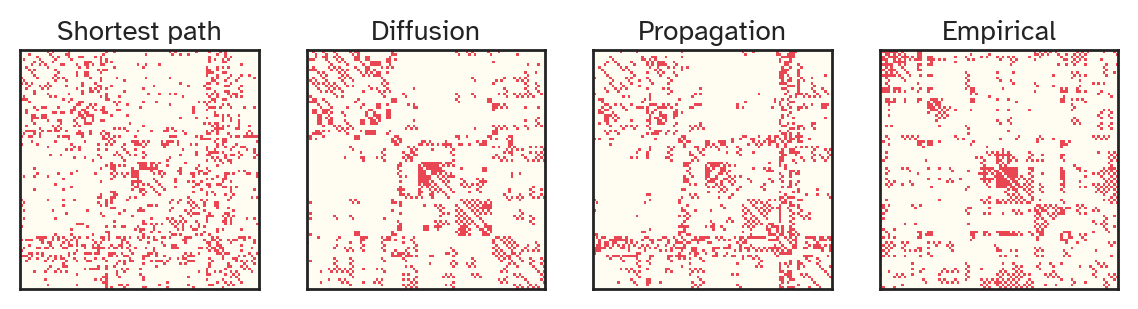

In [66]:
fig, axes = plt.subplot_mosaic([["A", "B", "C","D"]], 
                               figsize=(viz.cm_to_inch((18,4))),
                               dpi=200)
viz.plot_matrix(sp_networks[:,:,-1],
                cbar=False,sns_kwargs=sns_kwargs,axis=axes["A"])
viz.plot_matrix(rd_networks[:,:,-1], 
                cbar=False, sns_kwargs=sns_kwargs, axis=axes["B"])
viz.plot_matrix(pd_networks[:,:,-1], 
                cbar=False, sns_kwargs=sns_kwargs, axis=axes["C"])

viz.plot_matrix(empirical_consensus, 
                cbar=False, sns_kwargs=sns_kwargs, axis=axes["D"])
axes["A"].set_title("Shortest path")
axes["B"].set_title("Diffusion")
axes["C"].set_title("Propagation")
axes["D"].set_title("Empirical")
plt.savefig("figures/HCP/generated_adjmats.pdf",dpi=600,bbox_inches='tight');

In [91]:
# empirical_similarity = np.zeros((hcp_ya.shape[0],hcp_ya.shape[-1]))
# simulated_similarity = np.zeros((hcp_ya.shape[0],hcp_ya.shape[-1]))
# network_distance = np.zeros_like((hcp_ya),dtype=float)
# for subject in range(hcp_ya.shape[-1]):
#     empirical_similarity[:,subject] = ut.calculate_endpoint_similarity(hcp_ya[:,:,subject],
#                                                                        empirical_consensus)
#     simulated_similarity[:,subject] = ut.calculate_endpoint_similarity(simulated_networks[:,:,-1,subject],
#                                                                        empirical_consensus)
#     network_distance[:,:,subject] = hcp_ya[:,:,subject]-simulated_networks[:,:,-1,subject]
    
# empirical_similarity = pd.DataFrame(empirical_similarity.T,columns=labels)
# simulated_similarity = pd.DataFrame(simulated_similarity.T,columns=labels)
# averaged_network_distance = np.mean(network_distance,axis=-1)
# averaged_network_distance = pd.DataFrame(averaged_network_distance,columns=labels)

In [160]:
# from netneurotools.modularity import consensus_modularity

# test = consensus_modularity(averaged_network_distance.values,
#                             B="negative_sym",repeats=500)

In [151]:
# averaged_network_distance.index = averaged_network_distance.columns

In [161]:
# community_df = pd.DataFrame({
#     'label': averaged_network_distance.columns,
#     'community': test[0]  # e.g., test[0] if that's your community assignment array
# }).sort_values('community')

# reordered_matrix = averaged_network_distance.loc[community_df['label'], community_df['label']]

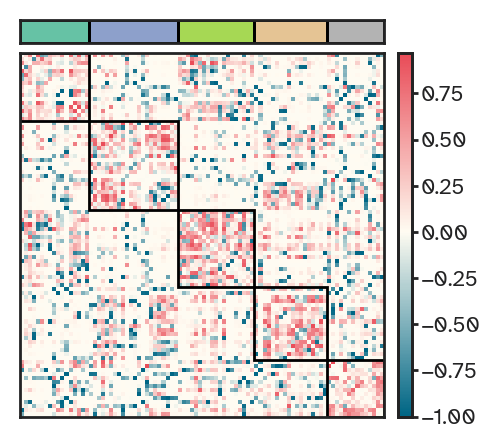

In [179]:
# plt.figure(figsize=(viz.cm_to_inch((6,6))),dpi=200)
# ax = plt.gca()
# viz.plot_matrix(reordered_matrix,
#                 community_labels=sorted(list(test[0])),
#                 community_cmap="Set2",
#                 cbar=True,axis=ax,
#                 sns_kwargs={"cmap":viz_cmaps["db_bw_lr"],
#                             "xticklabels":False,
#                             "yticklabels":False,"rasterized":True})
# fig.savefig("figures/HCP/consensus_modularity_matrix.pdf",dpi=600,bbox_inches='tight')

In [70]:
rd_similarities = np.zeros((n_nodes,n_nodes,rd_networks.shape[-1]))
sp_similarities = np.zeros((n_nodes,n_nodes,sp_networks.shape[-1]))
pd_similarities = np.zeros((n_nodes,n_nodes,pd_networks.shape[-1]))

for i in range(rd_networks.shape[-1]):
    rd_similarities[:,:,i] = hcp_ya[:,:,i] - rd_networks[:,:,i]
    sp_similarities[:,:,i] = hcp_ya[:,:,i] - sp_networks[:,:,i]
    pd_similarities[:,:,i] = hcp_ya[:,:,i] - pd_networks[:,:,i]


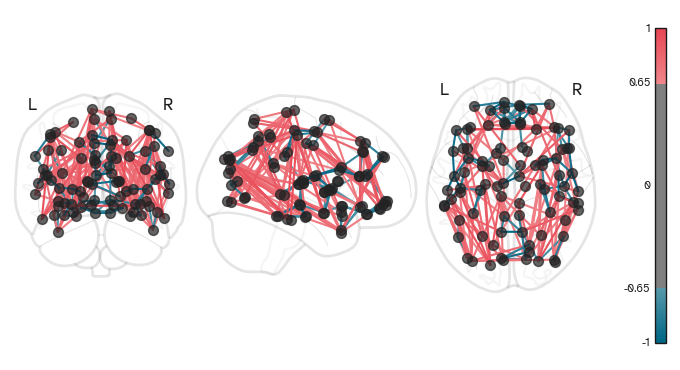

In [75]:
from nilearn.plotting import plot_connectome

plot_connectome(pd_similarities.mean(-1),
                coordinates,
                node_color=viz_colors["neutrals"]["HALF_BLACK"],
                edge_cmap=viz_cmaps["db_bw_lr"],
                edge_threshold="95%",
                alpha=0.1,
                colorbar=True,
                edge_kwargs={"linewidth":1.5},
                node_kwargs={"alpha":0.7})
plt.savefig("figures/HCP/PD_network difference.pdf",dpi=600,bbox_inches='tight');

In [166]:
# left_data = simulated_similarity.iloc[:,::2].copy()
# right_data = simulated_similarity.iloc[:,1::2].copy()
# left_surfdata = parcellation.map_to_labels(left_data.mean(1),lh_vertex_labels)
# right_surfdata = parcellation.map_to_labels(right_data.mean(1),rh_vertex_labels)

# left_data = averaged_network_distance.mean(0).iloc[::2].copy()
# right_data = averaged_network_distance.mean(0).iloc[1::2].copy()

left_data = test[0][::2].copy()
right_data = test[0][1::2].copy()
left_surfdata, right_surfdata = ut.data_to_surfdata(left_data = left_data, 
                                                    right_data = right_data, 
                                                    lh_surfaces=lh_vertex_labels, 
                                                    rh_surfaces=rh_vertex_labels)


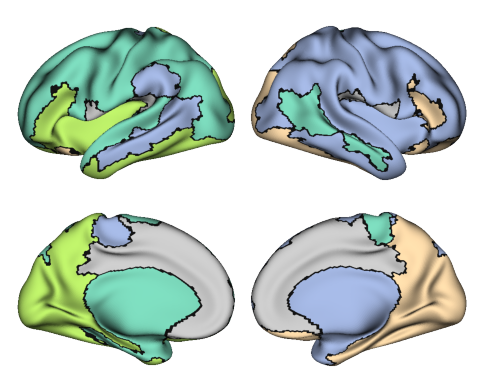

In [172]:
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']


p = Plot(surf_lh=lh, surf_rh=rh,
         brightness=0.8)
p.add_layer({'left':left_surfdata, 
             'right':right_surfdata}, 
            cmap="Set2",cbar=False)

p.add_layer({'left':left_surfdata, 
             'right':right_surfdata}, 
            cmap='binary_r',
            as_outline=True,
            cbar=False)
fig = p.build()
fig.savefig("figures/HCP/communities_difference.pdf", dpi=600, bbox_inches="tight")

In [77]:
sp_sample_trajectories.shape, pd_sample_trajectories.shape, rd_sample_trajectories.shape

((90, 90, 5000, 32), (90, 90, 5000, 32), (90, 90, 5000, 32))

In [87]:
n_samples = sp_sample_trajectories.shape[-1]
hcp_ya[:,:,:n_samples].shape

(90, 90, 32)

In [100]:
simulated_embeddings, empirical_embeddings, pca = ut.calculate_trajectories(simulation_tensors_list=[sp_sample_trajectories, 
                                                                             rd_sample_trajectories, 
                                                                             pd_sample_trajectories], 
                                                                            empirical_tensor= hcp_ya)


In [ ]:
simulated_embeddings[0][0].shape

(32, 5000, 3)

In [94]:
empirical_embeddings[].shape

(32, 3)

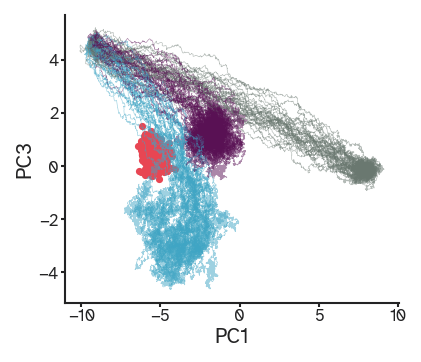

In [167]:
x,y = 0,2
alpha = 0.5
lw = 0.3
plt.figure(figsize=viz.cm_to_inch((7,6)), dpi=150)

for subject in range(n_samples):
    plt.plot(simulated_embeddings[0][subject][:,x],
            simulated_embeddings[0][subject][:,y],
            lw=lw,alpha=alpha, color = viz_colors["colds"]["LAKE_BLUE"],
            rasterized=True)
    plt.plot(simulated_embeddings[1][subject][:,x],
            simulated_embeddings[1][subject][:,y],lw=lw,alpha=alpha,
            color = viz_colors["neutrals"]["OLIVE_GRAY"], 
            rasterized=True)
    plt.plot(simulated_embeddings[2][subject][:,x],
            simulated_embeddings[2][subject][:,y],lw=lw,alpha=alpha, 
            color = viz_colors["purples"]["PURPLER"], 
            rasterized=True)

# First plot the empirical data points as a scatter plot
plt.scatter(empirical_embeddings[:,x],
            empirical_embeddings[:,y],
            s=6,
            alpha=1,
            color=viz_colors["warms"]["LECKER_RED"],
            )

plt.tight_layout(w_pad=0.1)
plt.xlabel(f"PC{x+1}")
plt.ylabel(f"PC{y+1}")
sns.despine()
plt.savefig(f"figures/HCP/pca_embeddings_PC{x+1}{y+1}.pdf",dpi=600,bbox_inches='tight');


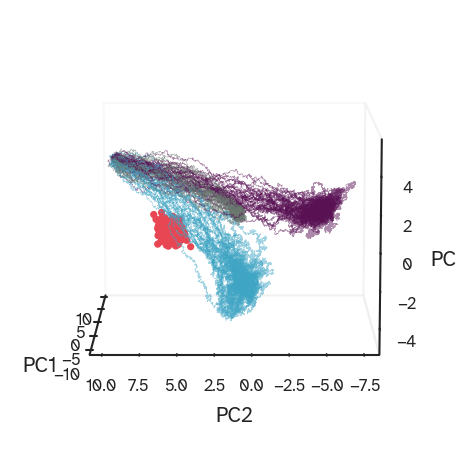

In [180]:
fig = plt.figure(figsize=viz.cm_to_inch((8,8)), dpi=150)
ax = fig.add_subplot(111, projection='3d')

x, y, z = 0, 1, 2  # Using first three principal components
alpha = 0.5
lw = 0.3

# Plot simulated trajectories
for subject in range(n_samples):
    ax.plot(simulated_embeddings[0][subject][:,x],
            simulated_embeddings[0][subject][:,y],
            simulated_embeddings[0][subject][:,z],
            lw=lw, alpha=alpha, color=viz_colors["colds"]["LAKE_BLUE"],
            rasterized=True)
    ax.plot(simulated_embeddings[1][subject][:,x],
            simulated_embeddings[1][subject][:,y],
            simulated_embeddings[1][subject][:,z],
            lw=lw, alpha=alpha, color=viz_colors["neutrals"]["OLIVE_GRAY"],
            rasterized=True)
    ax.plot(simulated_embeddings[2][subject][:,x],
            simulated_embeddings[2][subject][:,y],
            simulated_embeddings[2][subject][:,z],
            lw=lw, alpha=alpha, color=viz_colors["purples"]["PURPLER"],
            rasterized=True)

# Plot empirical data points
ax.scatter(empirical_embeddings[:,x],
          empirical_embeddings[:,y],
          empirical_embeddings[:,z],
          s=6, 
          alpha=1, 
          color=viz_colors["warms"]["LECKER_RED"])

ax.set_xlabel(f'PC{x+1}')
ax.set_ylabel(f'PC{y+1}')
ax.set_zlabel(f'PC{z+1}')

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# ax.xaxis.pane.set_edgecolor(viz_colors["neutrals"]["HALF_BLACK"])
# ax.yaxis.pane.set_edgecolor(viz_colors["neutrals"]["HALF_BLACK"])
# ax.zaxis.pane.set_edgecolor(viz_colors["neutrals"]["HALF_BLACK"])

# Adjust viewing angle for better visualization
ax.view_init(elev=10, azim=180)
plt.tight_layout()
#plt.savefig("figures/HCP/pca_embeddings_3D.pdf", dpi=600, bbox_inches='tight')

In [185]:
simulated_embeddings[0].shape

(32, 5000, 3)

In [189]:
empirical_embeddings.shape

(373, 3)

In [194]:
last_points = []
for _,embedding in simulated_embeddings.items():
    last_points.append(embedding[:,-1,:])
last_points = np.array(last_points).mean(1)
last_points = np.vstack([last_points, empirical_embeddings.mean(0)])
last_points.shape

(4, 3)

In [195]:
embeddings_distance = pd.DataFrame(squareform(pdist(last_points, metric='euclidean')))
embeddings_distance.columns = ["Shortest path", "Diffusion", "Propagation", "Empirical"]
embeddings_distance.index = ["Shortest path", "Diffusion", "Propagation", "Empirical"]

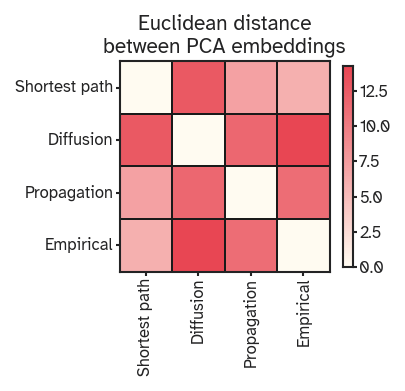

In [196]:
plt.figure(figsize=(viz.cm_to_inch((7,7))), dpi=150)
sns.heatmap(embeddings_distance,
            cmap=viz_cmaps["db_bw_lr"],
            center=0,
            square=True,
            linewidths=0.1,
            linecolor='k',
            cbar_kws={"shrink":0.72})

plt.title("Euclidean distance\nbetween PCA embeddings")
sns.despine(left=False, bottom=False, right=False, top=False)
plt.tight_layout()
plt.savefig("figures/HCP/pca_embeddings_distance.pdf", dpi=600, bbox_inches='tight')

In [198]:
embeddings_distance["Empirical"]

Shortest path     5.926907
Diffusion        14.269698
Propagation      11.162022
Empirical         0.000000
Name: Empirical, dtype: float64

In [199]:
rd_networks.shape

(90, 90, 373)

In [200]:
diffusion_measures = ut.compute_graph_metrics_parallel(rd_networks,
                                                    empirical_consensus,
                                                    euclidean_distances,
                                                    coordinates)
diffusion_measures.to_csv("results/HCP/diffusion_measures_373_variable_alpha.csv",index=False)
diffusion_measures = pd.read_csv("results/HCP/diffusion_measures_373_variable_alpha.csv")

Computing graph metrics:   0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

In [202]:
shortest_path_measures = ut.compute_graph_metrics_parallel(sp_networks,
                                                    empirical_consensus,
                                                    euclidean_distances,
                                                    coordinates)
shortest_path_measures.to_csv("results/HCP/shortest_path_measures_373_variable_alpha.csv",index=False)
shortest_path_measures = pd.read_csv("results/HCP/shortest_path_measures_373_variable_alpha.csv")

  0%|          | 0/373 [00:00<?, ?it/s]

In [203]:
propagation_measures = ut.compute_graph_metrics_parallel(pd_networks,
                                                    empirical_consensus,
                                                    euclidean_distances,
                                                    coordinates)
propagation_measures.to_csv("results/HCP/propagation_measures_373_variable_alpha.csv",index=False)
propagation_measures = pd.read_csv("results/HCP/propagation_measures_373_variable_alpha.csv")

  0%|          | 0/373 [00:00<?, ?it/s]

In [201]:
# empirical_measures = ut.compute_graph_metrics_parallel(hcp_ya,
#                                                     empirical_consensus,
#                                                     euclidean_distances,
#                                                     coordinates)
# empirical_measures.to_csv("results/HCP/empirical_measures_373.csv",index=False)
empirical_measures = pd.read_csv("results/HCP/empirical_measures_373.csv")

In [1]:
from bct import randmio_und, latmio_und

In [204]:
# randomized_networks = np.zeros_like(hcp_ya)
# latticized_networks = np.zeros_like(hcp_ya)

# for subject in tqdm(range(hcp_ya.shape[2])):
#     randomized_networks[:,:,subject] = randmio_und(hcp_ya[:,:,subject],
#                                                    itr=100, seed=subject)[0]
#     latticized_networks[:,:,subject] = latmio_und(hcp_ya[:,:,subject],
#                                                   itr=100, seed=subject)[0]

# np.save("results/HCP/randomized_networks_373.npy",randomized_networks)
# np.save("results/HCP/latticized_networks_373.npy",latticized_networks)

randomized_networks = np.load("results/HCP/randomized_networks_373.npy")
latticized_networks = np.load("results/HCP/latticized_networks_373.npy")

In [205]:
# randomized_measures = ut.compute_graph_metrics_parallel(randomized_networks,
#                                                      empirical_consensus,
#                                                      euclidean_distances,
#                                                      coordinates)
# latticized_measures = ut.compute_graph_metrics_parallel(latticized_networks,
#                                                      empirical_consensus,
#                                                      euclidean_distances,
#                                                      coordinates)
# randomized_measures.to_csv("results/HCP/randomized_measures_373.csv",index=False)
# latticized_measures.to_csv("results/HCP/latticized_measures_373.csv",index=False)

randomized_measures = pd.read_csv("results/HCP/randomized_measures_373.csv")
latticized_measures = pd.read_csv("results/HCP/latticized_measures_373.csv")

In [206]:
# measure_labels = ["diffusion distance",
#                     "shortest path distance",
#                     "propagation distance",
#                     "topological distance",
#                     "density",
#                     "wiring cost",
#                     "average clustering",
#                     "degree assortativity",
#                     "small-worldness",
#                     "endpoint similarity",
#                     "accuracy",
#                     "F1 score"]

# consensus_measures = np.zeros(len(measure_labels))
# consensus_measures[0] = gen.resistance_distance(empirical_consensus,coordinates).mean()
# consensus_measures[1] = gen.shortest_path_distance(empirical_consensus,coordinates).mean()
# consensus_measures[2] = gen.propagation_distance(empirical_consensus,coordinates).mean()
# consensus_measures[3] = gen.topological_distance(empirical_consensus,coordinates).mean()

# consensus_measures[4] = ut.check_density(empirical_consensus)
# consensus_measures[5] = ut.calculate_wiring_cost(empirical_consensus,euclidean_distances)
# G = nx.from_numpy_array(empirical_consensus)
# consensus_measures[6] = nx.average_clustering(G)
# consensus_measures[7] = nx.degree_assortativity_coefficient(G)
# consensus_measures[8] = ut.compute_omega(empirical_consensus)
# consensus_measures = pd.DataFrame([consensus_measures], columns=measure_labels)
# consensus_measures.to_csv("results/HCP/consensus_measures_373.csv",index=False)

consensus_measures = pd.read_csv("results/HCP/consensus_measures_373.csv")

In [207]:
diffusion_measures['model'] = 'Diffusion'
shortest_path_measures['model'] = 'Shortest path'
propagation_measures['model'] = 'Propagation'
empirical_measures['model'] = 'Empirical'
latticized_measures['model'] = 'Latticized'
randomized_measures['model'] = 'Randomized'

all_measures = pd.concat([
    shortest_path_measures,
    diffusion_measures,
    propagation_measures,
    empirical_measures,
    latticized_measures,
    randomized_measures,
], axis=0).reset_index(drop=True)

all_measures['sample_id'] = all_measures.groupby('model').cumcount()

all_measures.replace([np.inf, -np.inf], np.nan, inplace=True)
# all_measures.to_csv("results/HCP/all_measures_373.csv",index=False)

# all_measures = pd.read_csv("results/HCP/all_measures_373.csv")

In [208]:
all_measures.head()

,diffusion distance,shortest path distance,propagation distance,topological distance,density,wiring cost,average clustering,degree assortativity,small-worldness,endpoint similarity,accuracy,F1 score,model,sample_id
0,8.912130,1.928889,1.660164,0.810201,0.134582,6.778079,0.247644,-0.298509,0.698108,0.188581,78.345679,0.181139,Shortest path,0
1,6.433948,1.851358,1.467459,0.822292,0.165293,8.529345,0.208658,-0.175298,0.723551,0.219795,76.938272,0.217755,Shortest path,1
2,6.940022,1.876049,1.490791,0.825266,0.155306,7.876356,0.216180,-0.217631,0.720956,0.210392,77.481481,0.209705,Shortest path,2
3,8.917647,1.938519,1.608483,0.818439,0.132834,6.753913,0.221527,-0.306934,0.733992,0.179799,78.419753,0.178571,Shortest path,3
4,9.255494,1.930617,1.626428,0.813456,0.133333,6.788716,0.244840,-0.358149,0.705668,0.167640,77.975309,0.163227,Shortest path,4


In [210]:
colors = [viz_colors["colds"]["LAKE_BLUE"], # shortest path
          viz_colors["neutrals"]["OLIVE_GRAY"], # diffusion
          viz_colors["purples"]["PURPLER"], # propagation
          viz_colors["warms"]["LECKER_RED"], # empirical
          viz_colors["neutrals"]["GRAY"], # latticized
          viz_colors["neutrals"]["GRAY"]] # randomized

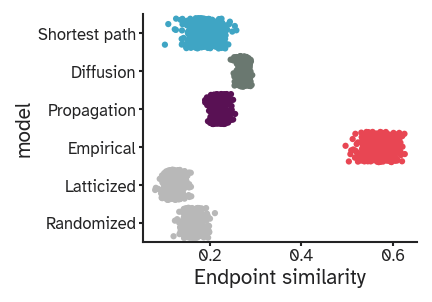

In [232]:
plt.figure(figsize=(viz.cm_to_inch((6,5))), dpi=150)
measure = "endpoint similarity"
sns.stripplot(data=all_measures, 
              y="model",
              x=measure,
              hue="model",
              size=3,
              jitter=0.4,
              palette=colors)

empirical_values = all_measures[all_measures['model'] == 'Empirical'][measure]
plt.xlabel(measure.capitalize())

#plt.xlim(0.05,0.15)
sns.despine()
#plt.savefig(f"figures/HCP/{measure}_stripplot_373.pdf",dpi=600,bbox_inches='tight');

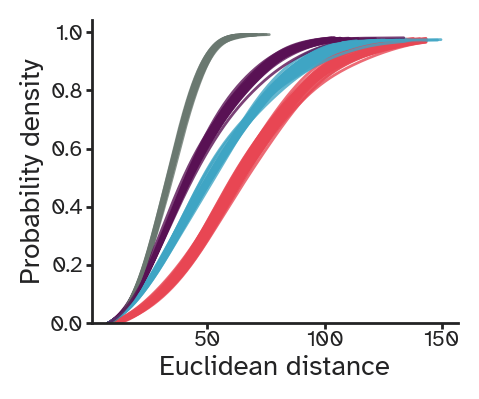

In [226]:
plt.figure(figsize=(viz.cm_to_inch((6,5))), dpi=200)
cumu = True

for subject in range(n_samples):
    sns.kdeplot(euclidean_distances[hcp_ya[:,:,subject].astype(bool)],
                lw=1,
                alpha=0.8,
                color=colors[3],
                bw_adjust=1.5,cut=0,cumulative=cumu,label="Empirical")
    sns.kdeplot(euclidean_distances[rd_networks[:,:,subject].astype(bool)],
                lw=1,
                alpha=0.8,
                bw_adjust=1.5,cut=0,
                color=colors[1],
                cumulative=cumu)
    sns.kdeplot(euclidean_distances[sp_networks[:,:,subject].astype(bool)],
                lw=1,
                alpha=0.8,
                bw_adjust=1.5,cut=0,
                color=colors[0],
                cumulative=cumu)
    sns.kdeplot(euclidean_distances[pd_networks[:,:,subject].astype(bool)],
                lw=1,
                alpha=0.8,
                bw_adjust=1.5,cut=0,
                color=colors[2],
                cumulative=cumu)

#plt.legend(bbox_to_anchor=(1,1),frameon=False)
plt.xlabel('Euclidean distance')
plt.ylabel('Probability density')
sns.despine()
#plt.savefig("figures/HCP/kdeplot_373.pdf",dpi=600,bbox_inches='tight');

In [220]:
hcp_ya[:,:,subject].shape

(90, 90)